<a href="https://colab.research.google.com/github/4nchez/Colab-Jupiter/blob/master/Kaggle_Challenge_Dogs_vs_Cats_Binary_Image_Classification_using_Keras_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Challenge : Dogs-vs-Cats - Binary Image Classification using Keras
해당 포스트는 [Kaggle  Dogs-vs-Cats challenge](https://www.kaggle.com/c/dogs-vs-cats) 해결하기위해 만들었으며, 여러 가지 자료들을 참고하여 만든 포스트 입니다.


*   개발 환경 : google colab, Python3, Tensorflow, Keras
*   실험 모델 : VGG16(Transfer Learning)
*   실험에 쓰인 데이터 : Kaggle Dogs vs Cats challenge
*   Test {개: 1,000, 고양이: 1,000} (총 2,000개)
*   Training {개: 5,000, 고양이: 5,000} (총 10,000개)
*   Validation {개: 2,500, 고양이: 2,500} (총 5,000개)
*   IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

GPU 사용

In [1]:
!nvidia-smi

Thu Sep 24 06:17:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

구글 드라이브 연동 코드

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states" #실험에 쓴 모델을 저장할 드라이브 경로
IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs" #구글 드라이브에 저장되어 있는 데이터셋(이미지)
import sys
sys.path.append('./drive/My Drive/Colab Notebooks')
import kr_helper_funcs as kru

## Kaggle  Dogs-vs-Cats challenge Dataset
Kaggle train.zip 에는 개와 고양이의 이미지 25,000 개 (고양이 색상 이미지 12,500 개 및 다양한 크기의 개 색상 이미지 12,500 개)가 포함되어 있습니다.

train Data 중 별도의 프로그램을 사용하여 고양이와 개에 개에 각각 5,000개의 훈련 이미지, 고양이와 개에 대한 2,500개의 평가 이미지, 고양이와 개에 개에 각각 1,000개의 테스트 이미지로 구성된 작은 데이터 세트를 만들었습니다. 그런 다음 이미지 Dataset.zip 파일을 Google 드라이브에 업로드했습니다.

zip 파일 cats_vs_dogs_images_small.zip은 내 Google 드라이브의 IMAGES_ZIP_DIR에서 사용할 수 있습니다. 아래 코드 셀은 로컬로 다운로드하고 /tmp 폴더에 이미지 압축을 풉니다.

In [4]:
import sys, os, random
import numpy as np
import tensorflow as tf
import keras
print('Using Tensorflow version ', tf.__version__)
print('Using keras version ', keras.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
 
plt.style.use('seaborn')
 
seed = 123
random.seed(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
 
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  2.3.0
Using keras version  2.4.3


In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import os, shutil
import zipfile
 
#!cp $(IMAGES_ZIP_DIR/images_small.zip" /tmp
source_file = os.path.join(IMAGES_ZIP_DIR, 'cats_vs_dogs_images_small.zip')
local_zip = '/tmp/cats_vs_dogs_images_small.zip'
 
print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)
 
assert os.path.exists(local_zip)
 
print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp')
zip_ref.close()

Copying from drive /content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs/cats_vs_dogs_images_small.zip to /tmp/cats_vs_dogs_images_small.zip...
Extracting all images...


## 실험에 쓰일 데이터 파일 연결

In [7]:
images_root = "/tmp" # /content/drive/My Drive/img
assert os.path.exists(images_root), "%s folder does not exist!" % images_root
 
train_root = os.path.join(images_root,'training')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')
 
eval_root = os.path.join(images_root,'validation')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')
 
test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [8]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
 
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

# 기본 vgg16

In [ ]:
from keras.activations import softmax, relu, sigmoid

vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])    
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
# for layer in model.layers:
#     if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
#       layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))

model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)              

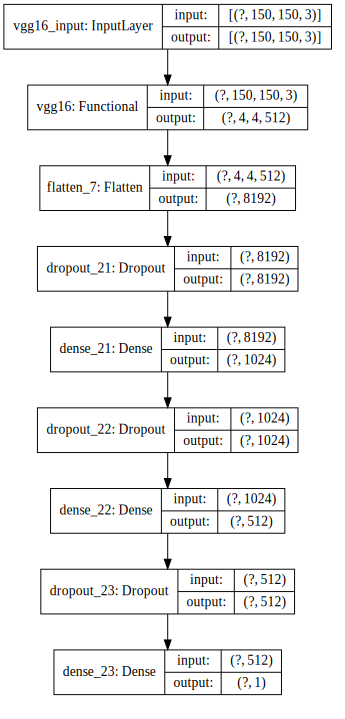

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model_xfer.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
312/312 [==============================] - 45s 144ms/step - loss: 0.3643 - acc: 0.8345 - val_loss: 0.2607 - val_acc: 0.8848
Epoch 2/50
312/312 [==============================] - 44s 143ms/step - loss: 0.2783 - acc: 0.8791 - val_loss: 0.2420 - val_acc: 0.8952
Epoch 3/50
312/312 [==============================] - 44s 142ms/step - loss: 0.2471 - acc: 0.8933 - val_loss: 0.2281 - val_acc: 0.9022
Epoch 4/50
312/312 [==============================] - 45s 143ms/step - loss: 0.2358 - acc: 0.9004 - val_loss: 0.2346 - val_acc: 0.9016
Epoch 5/50
312/312 [==============================] - 44s 142ms/step - loss: 0.2261 - acc: 0.9035 - val_loss: 0.2292 - val_acc: 0.9054
Epoch 6/50
312/312 [==============================] - 44s 142ms/step - loss: 0.2173 - acc: 0.9070 - val_loss: 0.2258 - val_acc: 0.9048
Epoch 7/50
312/312 [==============================] - 44s 141ms/step - loss: 0.2010 - acc: 0.9150 - val_loss: 0.23

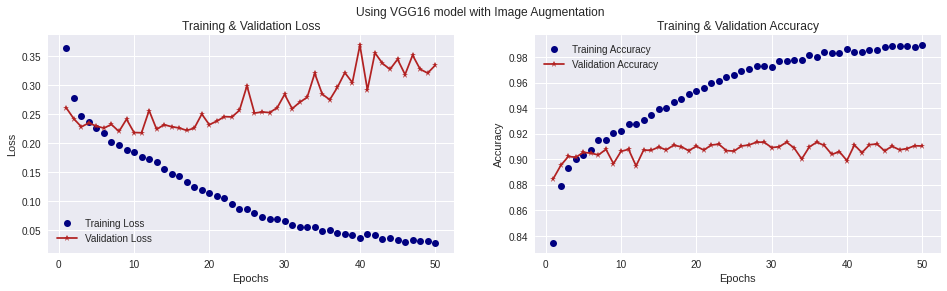

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16')

In [ ]:
# 성능 평가
loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
312/312 [==============================] - 30s 97ms/step - loss: 0.0026 - acc: 1.0000
Training data  -> loss: 0.003, acc: 1.000
156/156 [==============================] - 15s 97ms/step - loss: 0.3341 - acc: 0.9105
Cross-val data -> loss: 0.334, acc: 0.910
62/62 [==============================] - 6s 103ms/step - loss: 0.3579 - acc: 0.9017
Testing data   -> loss: 0.358, acc: 0.902


# mse 인 vgg16

In [ ]:
from keras.activations import softmax, relu, sigmoid

vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])    
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      # layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))

model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model')

In [ ]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

# 활성함수가 sigmoid 인 vgg16


In [53]:
from keras.activations import softmax, relu, sigmoid

vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
for layer in vgg_base.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias)
    
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])    
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))

model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)              

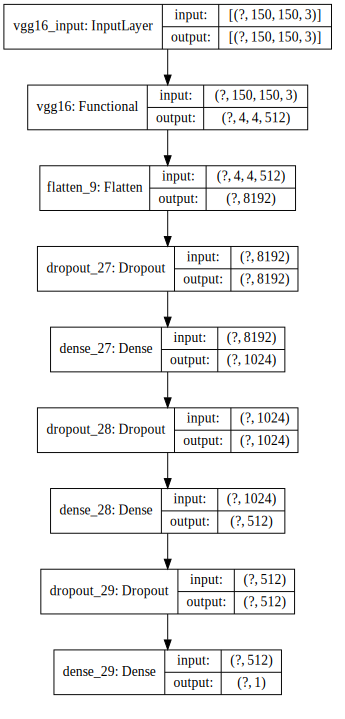

In [54]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 54s 174ms/step - loss: 0.7083 - acc: 0.5025 - val_loss: 0.6961 - val_acc: 0.5000
Epoch 2/50
312/312 [==============================] - 54s 173ms/step - loss: 0.7064 - acc: 0.4949 - val_loss: 0.7141 - val_acc: 0.5002
Epoch 3/50
137/312 [============>.................] - ETA: 20s - loss: 0.7048 - acc: 0.4888

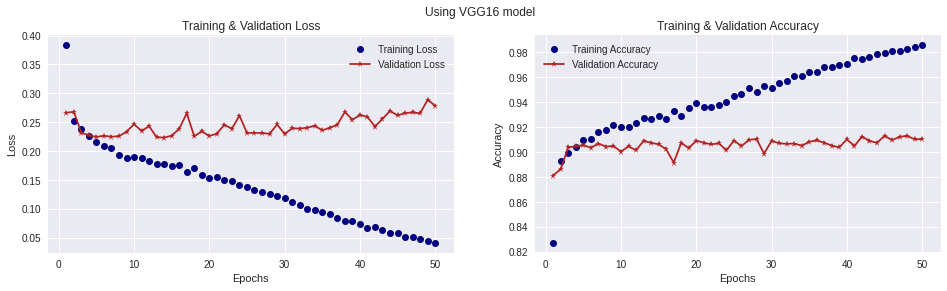

In [51]:
kru.show_plots(hist.history, plot_title='Using VGG16 model')

In [52]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
312/312 [==============================] - 34s 108ms/step - loss: 0.0081 - acc: 1.0000
Training data  -> loss: 0.008, acc: 1.000
156/156 [==============================] - 17s 108ms/step - loss: 0.2782 - acc: 0.9103
Cross-val data -> loss: 0.278, acc: 0.910
62/62 [==============================] - 7s 107ms/step - loss: 0.2771 - acc: 0.9057
Testing data   -> loss: 0.277, acc: 0.906


# 활성함수가 sigmoid 이며 mse 인 vgg16


In [ ]:
from keras.activations import softmax, relu, sigmoid

vgg_base = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
alpha = 0.00002  # weight decay coefficient
for layer in vgg_base.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias)
    
model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])    
vgg_base.trainable = False
# model_vgg16.layers[-1].activation=None
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
      # layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      layer.activation = sigmoid
    # if hasattr(layer, 'bias_regularizer') and layer.use_bias:
    #   layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))

model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model')

In [ ]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))